In [20]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, datasets
import pandas as pd
from tqdm import tqdm

import spacy
import numpy as np

import random
import math
import time

from seq2seq import utils, helpers
import re
import os
import pickle

# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
DATASET_PATH = f"../.data/miguel"

## Load dataset

In [22]:
def load_dataset(filename_src, filename_trg):
    file_src = open(filename_src, encoding='utf-8').read().split('\n')
    file_trg = open(filename_trg, encoding='utf-8').read().split('\n')
    assert len(file_src) == len(file_trg)
    return file_src, file_trg

In [23]:
(train_src, train_trg) = load_dataset(filename_src=f"{DATASET_PATH}/europarl.en", filename_trg=f"{DATASET_PATH}/europarl.es")
(dev_src, dev_trg) = load_dataset(filename_src=f"{DATASET_PATH}/dev.en", filename_trg=f"{DATASET_PATH}/dev.es")
(test_src, test_trg) = load_dataset(filename_src=f"{DATASET_PATH}/test.en", filename_trg=f"{DATASET_PATH}/test.es")

In [24]:
print(f"Train => Total sentences: SRC={len(train_src)} | TRG={len(train_trg)}")
print(f"Dev => Total sentences: SRC={len(dev_src)} | TRG={len(dev_trg)}")
print(f"Test => Total sentences: SRC={len(test_src)} | TRG={len(test_trg)}")

Train => Total sentences: SRC=1960642 | TRG=1960642
Dev => Total sentences: SRC=3004 | TRG=3004
Test => Total sentences: SRC=3001 | TRG=3001


## Qualitative review of the dataset


From a qualitative inspection of the raw files, I have encountered the following problems:

Train:
- Two files (en, es)
- `<0 `
- Chars like: `NBSP`
- Short sentences, around 50-100 words
- Sentences starting with `(`
- UTF-8
- No tokenization done (like replacing numbers with `NUM`, dates with `DATE` or things like that)
- Words/Sentences hard to translate: `(H-0521/00)`, `78/319/CEE`
- Last line empty
- Some sentences end with period, others don't

Dev:
- Two files (en, es)
- Chars like: `NBSP`, `ZWSP`
- Short sentences, around 50-100 words
- Sentences starting with `"`
- UTF-8
- No tokenization done (like replacing numbers with `NUM`, dates with `DATE` or things like that)
- Words/Sentences hard to translate: `Wolfgang Schäuble`, `Hašek`
- Last line empty
- Some sentences end with period, others don't


Test:
- Two files (en, es)
- `<seg id=` tags
- Chars like: `NBSP`, `ZWSP`
- Short sentences, around 50-100 words
- Sentences starting with `"`
- UTF-8
- No tokenization done (like replacing numbers with `NUM`, dates with `DATE` or things like that)
- Words/Sentences hard to translate: `Nikolaev`, `www.kpks.cz`, `(0-0)`
- Last line empty
- Some sentences end with period, others don't
- Multiple formats for datates: `20.12.2012`

Sizes:

```bash
-rw-r--r-- 1 salvacarrion salvacarrion 373K ene 23  2013 dev.en
-rw-r--r-- 1 salvacarrion salvacarrion 417K ene 23  2013 dev.es
-rw-rw-r-- 1 salvacarrion salvacarrion 281M mar 31  2020 europarl.en
-rw-rw-r-- 1 salvacarrion salvacarrion 310M mar 31  2020 europarl.es
-rw-r--r-- 1 salvacarrion salvacarrion 329K mar 31  2020 test.en
-rw-r--r-- 1 salvacarrion salvacarrion 374K mar 31  2020 test.es
```

In [25]:
def view_raw(src_raw, trg_raw, indices):
    for i, idx in enumerate(indices):
        (src, trg) = src_raw[idx], trg_raw[idx]
        print(f"#{i+1}: " + "-"*20)
        print(f"src => {src}")
        print(f"trg => {trg}")
    print("")


In [26]:
n=3
print("Head: " + "#"*20)
print("(Firsts) Train dataset: " + "*"*20)
view_raw(train_src, train_trg, indices=range(0, n))

print("(Firsts) Dev dataset: " + "*"*20)
view_raw(dev_src, dev_trg, indices=range(0, n))

print("(Firsts) Test dataset: " + "*"*20)
view_raw(test_src, test_trg, indices=range(0, n))

print("Tail: " + "#"*20)
print("(Lasts) Train dataset: " + "*"*20)
view_raw(train_src, train_trg, indices=range(-1,-n-1,-1))

print("(Lasts) Dev dataset: " + "*"*20)
view_raw(dev_src, dev_trg, indices=range(-1,-n-1,-1))

print("(Lasts) Test dataset: " + "*"*20)
view_raw(test_src, test_trg, indices=range(-1,-n-1,-1))


Head: ####################
(Firsts) Train dataset: ********************
#1: --------------------
src => Resumption of the session
trg => Reanudación del período de sesiones
#2: --------------------
src => I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
trg => Declaro reanudado el período de sesiones del Parlamento Europeo, interrumpido el viernes 17 de diciembre pasado, y reitero a Sus Señorías mi deseo de que hayan tenido unas buenas vacaciones.
#3: --------------------
src => Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
trg => Como todos han podido comprobar, el gran "efecto del año 2000" no se ha producido. En cambio, los ciudadanos de varios de nuestros países han sido víctimas de

## Preprocessing dataset

From the results above we need to do the following steps in order to clean the input data:

- Remove last empty row from: Train, Dev and Test
- Remove XML tags


In [ ]:
def preprocess_dataset(train_src, train_trg):
    train_src_new, train_trg_new = [], []
    p_xml = re.compile("^<seg id=\"\d+\">")
    p_whitespace = re.compile(" +")

    total = len(train_src)
    for i in tqdm(range(total), total=total):
        src, trg = train_src[i], train_trg[i]

        # Remove html
        src = p_xml.sub('', src)
        trg = p_xml.sub('', trg)

        # Remove repeated whitespaces "   " => " "
        src = p_whitespace.sub(' ', src)
        trg = p_whitespace.sub(' ', trg)

        # Strip whitespace
        src = src.strip()
        trg = trg.strip()

        # Remove empty line
        if len(src) > 0 and len(trg) > 0:
            train_src_new.append(src)
            train_trg_new.append(trg)
    return train_src_new, train_trg_new

In [ ]:
train_src, train_trg = preprocess_dataset(train_src, train_trg)
dev_src, dev_trg = preprocess_dataset(dev_src, dev_trg)
test_src, test_trg = preprocess_dataset(test_src, test_trg)


# Convert to pandas
data_raw = {lang_src: [line for line in file_src], lang_trg: [line for line in file_trg]}
data_df = pd.DataFrame(data_raw, columns=[lang_src, lang_trg])

In [27]:
train_lenghts = np.array([(len(src), len(trg)) for src, trg in zip(train_src, train_trg)])
dev_lenghts = np.array([(len(src), len(trg)) for src, trg in zip(dev_src, dev_trg)])
test_lenghts = np.array([(len(src), len(trg)) for src, trg in zip(test_src, test_trg)])

In [28]:
# Sort columns independently (ascending)
train_sort_len_idx = np.argsort(train_lenghts, axis=0)
dev_sort_len_idx = np.argsort(dev_lenghts, axis=0)
test_sort_len_idx = np.argsort(test_lenghts, axis=0)

In [29]:
train_min_len = train_lenghts.min(axis=0).astype(int)
dev_min_len = dev_lenghts.min(axis=0).astype(int)
test_min_len = test_lenghts.min(axis=0).astype(int)

train_max_len = train_lenghts.max(axis=0).astype(int)
dev_max_len = dev_lenghts.max(axis=0).astype(int)
test_max_len = test_lenghts.max(axis=0).astype(int)


print(f"Train => Range length: src={train_min_len[0]}-{train_max_len[0]} | trg={train_min_len[1]}-{train_max_len[1]}")
print(f"Dev => Range length: src={dev_min_len[0]}-{dev_max_len[0]} | trg={dev_min_len[1]}-{dev_max_len[1]}")
print(f"Test => Range length: src={test_min_len[0]}-{test_max_len[0]} | trg={test_min_len[1]}-{test_max_len[1]}")



Train => Range length: src=0-3950 | trg=0-4278
Dev => Range length: src=0-723 | trg=0-728
Test => Range length: src=0-507 | trg=0-705


In [30]:
def view_lengths(raw, indices):
    for i, idx in enumerate(indices):
        src, trg = raw[idx[0]], raw[idx[1]]
        print(f"#{i+1}: " + "-"*20)
        print(f"=> src (len={len(src)}; idx={idx[0]}) => {src}")
        print(f"=> trg (len={len(trg)}; idx={idx[1]}) => {trg}")
    print("")

In [31]:
n=3
print("Shortest: " + "#"*20)
print("(Shortest) Train dataset: " + "*"*20)
view_lengths(train_src, indices=train_sort_len_idx[:n])

print("(Shortest) Dev dataset: " + "*"*20)
view_lengths(dev_src, indices=dev_sort_len_idx[:n])

print("(Shortest) Test dataset: " + "*"*20)
view_lengths(test_src, indices=test_sort_len_idx[:n])

print("Longest: " + "#"*20)
print("(Longest) Train dataset: " + "*"*20)
view_lengths(train_src, indices=train_sort_len_idx[::-1][:n])

print("(Longest) Dev dataset: " + "*"*20)
view_lengths(dev_src, indices=dev_sort_len_idx[::-1][:n])

print("(Longest) Test dataset: " + "*"*20)
view_lengths(test_src, indices=test_sort_len_idx[::-1][:n])



Shortest: ####################
(Shortest) Train dataset: ********************
#1: --------------------
=> src (len=0; idx=1960641) => 
=> trg (len=0; idx=1960641) => 
#2: --------------------
=> src (len=1; idx=612155) => .
=> trg (len=1; idx=629620) => .
#3: --------------------
=> src (len=1; idx=611971) => .
=> trg (len=1; idx=629748) => .

(Shortest) Dev dataset: ********************
#1: --------------------
=> src (len=0; idx=3003) => 
=> trg (len=0; idx=3003) => 
#2: --------------------
=> src (len=4; idx=1880) => Debt
=> trg (len=5; idx=2113) => Peru:
#3: --------------------
=> src (len=5; idx=2113) => Peru:
=> trg (len=6; idx=179) => Review

(Shortest) Test dataset: ********************
#1: --------------------
=> src (len=0; idx=3000) => 
=> trg (len=0; idx=3000) => 
#2: --------------------
=> src (len=4; idx=1570) => Why?
=> trg (len=4; idx=2307) => Yes.
#3: --------------------
=> src (len=4; idx=2307) => Yes.
=> trg (len=7; idx=2308) => And no.

Longest: ################

In [32]:
# Get lengths
tr_src_len = train_lenghts[:, 0]
tr_trg_len = train_lenghts[:, 1]
dev_src_len = dev_lenghts[:, 0]
dev_trg_len = dev_lenghts[:, 1]
ts_src_len = test_lenghts[:, 0]
ts_trg_len = test_lenghts[:, 1]

# Pair data and labels
h_data = [tr_src_len, tr_trg_len, dev_src_len, dev_trg_len, ts_src_len, ts_trg_len]
h_labels = ['tr_src_len', 'tr_trg_len', 'dev_src_len', 'dev_trg_len', 'ts_src_len', 'ts_trg_len']

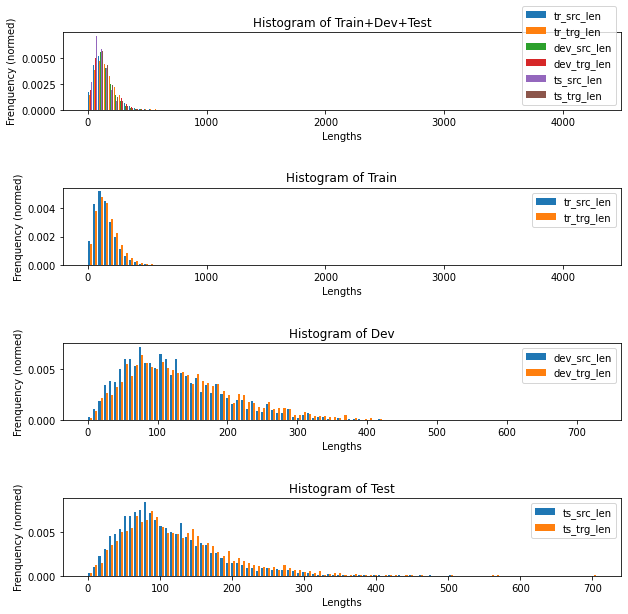

In [33]:
def get_hist(ax, data, labels, title, bins=100):
    # Draw the plot
    ax.hist(data, bins=bins, density=True, label=labels)

    # Title and labels
    ax.set_title(title)
    ax.set_xlabel("Lengths")
    ax.set_ylabel("Frenquency (normed)")
    ax.legend()


plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(4)
get_hist(axs[0], h_data, h_labels, f"Histogram of Train+Dev+Test")
get_hist(axs[1], h_data[0:2], h_labels[0:2], f"Histogram of Train")
get_hist(axs[2], h_data[2:4], h_labels[2:4], f"Histogram of Dev")
get_hist(axs[3], h_data[4:6], h_labels[4:6], f"Histogram of Test")

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplots_adjust(hspace=1.0)

In [34]:
# Get means
train_mean_len = train_lenghts.mean(axis=0).round().astype(int)
dev_mean_len = dev_lenghts.mean(axis=0).round().astype(int)
test_mean_len = test_lenghts.mean(axis=0).round().astype(int)

print(f"Train => Mean length: src={train_mean_len[0]} | trg={train_mean_len[1]}")
print(f"Dev => Mean length: src={dev_mean_len[0]} | trg={dev_mean_len[1]}")
print(f"Test => Mean length: src={test_mean_len[0]} | trg={test_mean_len[1]}")

Train => Mean length: src=149 | trg=162
Dev => Mean length: src=126 | trg=139
Test => Mean length: src=111 | trg=124


In [35]:

def get_percentiles(src_trg_lengths, lower_q, upper_q):
    p = np.percentile(src_trg_lengths,  [lower_q, upper_q], axis=0)
    (lb_tr_src_len, lb_tr_trg_len), (ub_tr_src_len, ub_tr_trg_len) = p

    print(f"- SRC ({lower_q}-{upper_q}%): {int(lb_tr_src_len)}-{int(ub_tr_src_len)}")
    print(f"- TRG ({lower_q}-{upper_q}%): {int(lb_tr_trg_len)}-{int(ub_tr_trg_len)}")

    return p

lower_q, upper_q = (1, 90)  # Percentage
print("Percentile Train:")
tr_p = get_percentiles(train_lenghts, *(lower_q, upper_q))
print("Percentile Dev:")
dev_p = get_percentiles(dev_lenghts, *(lower_q, upper_q))
print("Percentile Test:")
ts_p = get_percentiles(test_lenghts, *(lower_q, upper_q))


Percentile Train:
- SRC (1-90%): 15-266
- TRG (1-90%): 15-289
Percentile Dev:
- SRC (1-90%): 14-230
- TRG (1-90%): 16-253
Percentile Test:
- SRC (1-90%): 15-197
- TRG (1-90%): 14-222


In [36]:
tr_no_sent = np.sum(train_lenghts == 0, axis=0).astype(int)
dev_no_sent = np.sum(dev_lenghts == 0, axis=0).astype(int)
ts_no_sent = np.sum(test_lenghts == 0, axis=0).astype(int)

print(f"Train => Sentences with no words: SRC={tr_no_sent[0]} | TRG={tr_no_sent[1]}")
print(f"Dev => Sentences with no words: SRC={dev_no_sent[0]} | TRG={dev_no_sent[1]}")
print(f"Test => Sentences with no words: SRC={ts_no_sent[0]} | TRG={ts_no_sent[1]}")

Train => Sentences with no words: SRC=1 | TRG=1
Dev => Sentences with no words: SRC=1 | TRG=1
Test => Sentences with no words: SRC=1 | TRG=1
